In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
df=pd.read_csv("HDFCBANK.BO.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-01,533.0,536.500000,528.500000,532.500000,516.979248,75410.0
1,2016-04-04,534.5,536.224976,532.150024,534.650024,519.066589,70052.0
2,2016-04-05,534.0,538.325012,527.625000,529.150024,513.726807,158490.0
3,2016-04-06,532.5,533.400024,528.349976,530.750000,515.280212,87236.0
4,2016-04-07,535.0,535.500000,523.599976,527.825012,512.440491,79930.0


In [4]:
df.dropna(axis=0, inplace=True)

In [5]:
df1=df["Close"].values

In [6]:
df1=np.reshape(df1, (1231, 1))

In [7]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
def create_dataset(dataset, lag_var=1):
	datax, datay = [], []
	for i in range(len(dataset)-lag_var-1):
		a = dataset[i:(i+lag_var), 0]   ###i=0,1,2,3,4
		datax.append(a)
		datay.append(dataset[i + lag_var, 0])
	return np.array(datax), np.array(datay)

In [9]:
lag_var=10
X, y = create_dataset(df1, lag_var)

In [10]:
##splitting dataset into train and test split
train_size=int(len(X)*0.75)
test_size=len(X)-train_size
train_X,test_X=X[0:train_size,:],X[train_size:,:]

In [11]:
##splitting dataset into train and valid split
train_size=int(len(train_X)*0.75)
test_size=len(train_X)-train_size
tr_X,valid_X=train_X[0:train_size,:],train_X[train_size:len(train_X),:]

In [12]:
Trn_X =tr_X.reshape(tr_X.shape[0],tr_X.shape[1] , 1)
val_X =valid_X.reshape(valid_X.shape[0],valid_X.shape[1] , 1)

In [13]:
Trn_y=y[0:686]
val_y=y[686:915]

In [14]:
model=Sequential()
model.add(LSTM(80, return_sequences=True,input_shape=(10,1)))
model.add(LSTM(160))
model.add(Activation('exponential'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
# simple early stopping
es = EarlyStopping(monitor='val_loss', patience=1, mode='auto', verbose=1, restore_best_weights=True)

In [15]:
begin = time.time()
history = model.fit(Trn_X,Trn_y,validation_data=(val_X,val_y), epochs=1000, verbose=1, callbacks=[es])
time.sleep(1)
# store end time
end = time.time()

Epoch 1/1000
22/22 [==============================] - 5s 73ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 2/1000
22/22 [==============================] - 1s 33ms/step - loss: 3.6590e-04 - val_loss: 6.3693e-04
Epoch 3/1000
22/22 [==============================] - 1s 33ms/step - loss: 2.7454e-04 - val_loss: 0.0011
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping


(array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005]),
 <a list of 6 Text major ticklabel objects>)

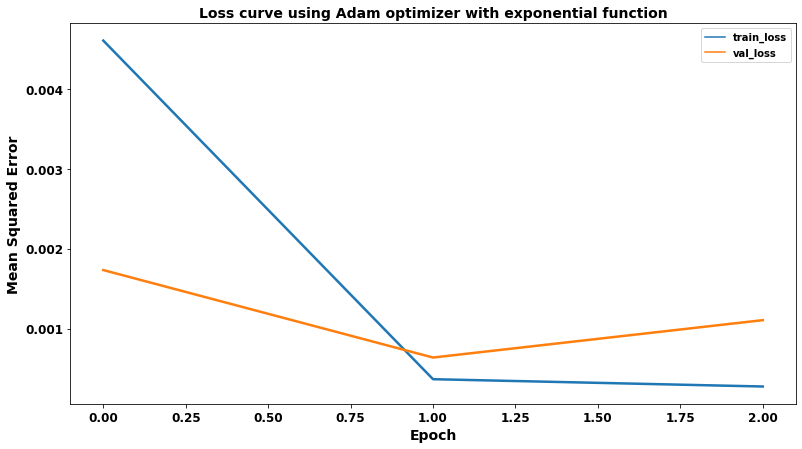

In [16]:
df_loss=pd.DataFrame()
df_loss['train_loss']=history.history['loss']
df_loss['val_loss']=history.history['val_loss']
df_loss.reset_index(inplace=True)
df_loss = df_loss.rename(columns = {'index':'Epoch'})

legend_properties = {'weight':'bold'}
fig, axes = plt.subplots(figsize=(13,7))
sns.lineplot(x='Epoch', y='value', hue='variable', 
             data=pd.melt(df_loss, ['Epoch']), color='red', linewidth=2.5)
plt.title("Loss curve using Adam optimizer with exponential function", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=14, fontweight="bold")
plt.ylabel("Mean Squared Error", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.legend(fontsize=12, prop=legend_properties)
plt.yticks(fontsize=12, fontweight="bold")
#plt.savefig("loss_rmsprop_exponential.jpg")

In [17]:
tst_X =test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)
X_trans=X.reshape(X.shape[0],X.shape[1] , 1)
tst_predict=model.predict(tst_X)
X_pred=model.predict(X_trans)

In [18]:
test_predict=scaler.inverse_transform(tst_predict)
X_predict=scaler.inverse_transform(X_pred)
y_original=scaler.inverse_transform(y.reshape(-1,1))

In [19]:
#mape test
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(y_original, X_predict)

2.1693711002758334

In [20]:
#mape test
mean_absolute_percentage_error(y_original[915:],test_predict)

3.6617653055782435

In [21]:
#mape val
mean_absolute_percentage_error(y_original[686:915],X_predict[686:915])

1.6959269141751263

In [22]:
#mape train
mean_absolute_percentage_error(y_original[:686],X_predict[:686])

1.663887877071168

In [23]:
#rmse full
math.sqrt(mean_squared_error(y_original, X_predict))

33.00743075639953

In [24]:
#rmse test
math.sqrt(mean_squared_error(y_original[915:],test_predict))

56.11038064418988

In [25]:
#rmse val
math.sqrt(mean_squared_error(y_original[686:915],X_predict[686:915]))

27.73021244214156

In [26]:
#rmse train
math.sqrt(mean_squared_error(y_original[:686],X_predict[:686]))

16.76589061755506

In [27]:
#r2 full
r2_score(y_original,X_predict)

0.9819158088953486

In [28]:
#r2 test
r2_score(y_original[915:],test_predict)

0.9318439683089783

In [29]:
#r2 val
r2_score(y_original[686:915],X_predict[686:915])

0.8561516509544509

In [30]:
#r2 train
r2_score(y_original[:686],X_predict[:686])

0.9904948220794173

In [32]:
df['Date']=pd.to_datetime(df["Date"])
df["month_year"]=df["Date"].dt.strftime('%Y-%m')
dates=df["month_year"].iloc[10:1230].values

In [33]:
final=pd.DataFrame()

In [34]:
final['real']=np.reshape(y_original, (1220,))
final['predicted']=np.reshape(X_predict, (1220,))
final['date']=dates

(array([ 400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.]),
 <a list of 8 Text major ticklabel objects>)

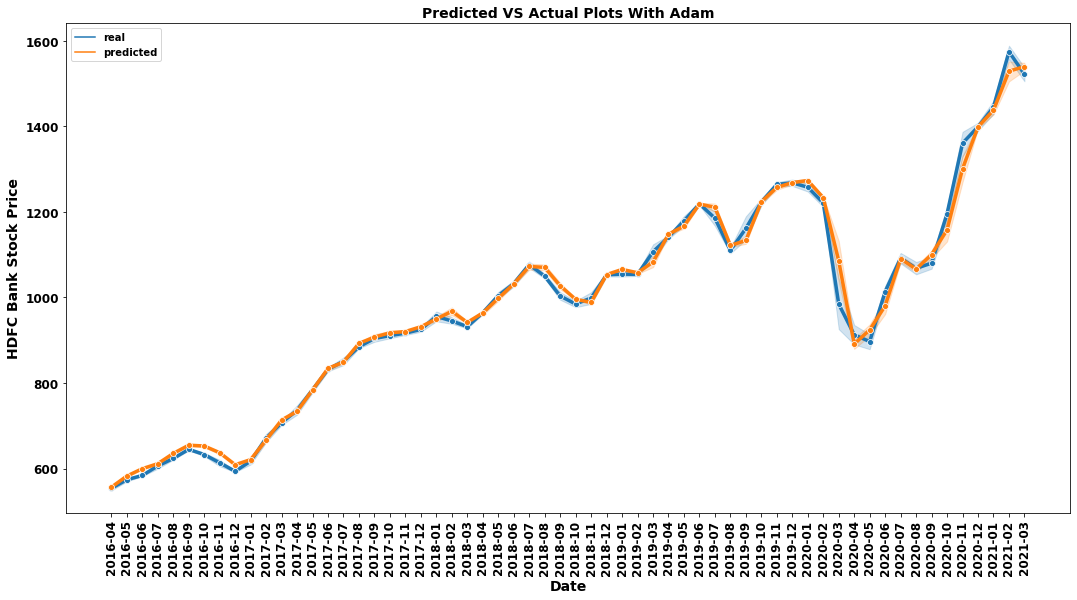

In [35]:
legend_properties = {'weight':'bold'}
fig, axes = plt.subplots(figsize=(18,9))
sns.lineplot(x='date', y='value', hue='variable', 
             data=pd.melt(final, ['date']), linewidth=3.5, marker = 'o')
plt.title("Predicted VS Actual Plots With Adam", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=14, fontweight="bold")
plt.ylabel("HDFC Bank Stock Price", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, rotation = 'vertical', fontweight="bold")
plt.legend(fontsize=12, prop=legend_properties)
plt.yticks(fontsize=12, fontweight="bold")
#plt.savefig("predicted_plot_adam_lag10.jpg")